Attempting to load search results from: ./work_dirs/cifar10_nasbnn_exp_notebook_run/search/info.pth.tar
Search results loaded successfully.

Total unique architectures evaluated (from vis_dict): 166
Search completed 10 evolutionary epochs (0 to 9).

--- Content of memory[0] (first 3 elements if available): ---
(0, 0, 24, 3, 1, 1, 1, 0, 48, 3, 1, 1, 1, 1, 48, 3, 1, 1, 2, 0, 128, 3, 2, 1, 2, 1, 128, 5, 2, 1, 3, 0, 196, 5, 2, 1, 3, 1, 256, 5, 2, 1)
(0, 0, 32, 3, 1, 1, 1, 0, 64, 3, 1, 1, 1, 1, 64, 3, 1, 1, 2, 0, 128, 5, 1, 1, 2, 1, 128, 5, 1, 1, 3, 0, 256, 5, 2, 1, 3, 1, 256, 5, 2, 1)

--- Content of memory[1] (first 3 elements if available): ---
(0, 0, 32, 3, 1, 1, 1, 0, 64, 3, 1, 1, 1, 1, 64, 3, 1, 1, 2, 0, 128, 3, 2, 1, 2, 1, 128, 5, 2, 1, 3, 0, 256, 5, 2, 1, 3, 1, 256, 5, 2, 1)
(0, 0, 32, 3, 1, 1, 1, 0, 64, 3, 1, 1, 1, 1, 64, 3, 1, 1, 2, 0, 128, 5, 1, 1, 2, 1, 128, 5, 1, 1, 3, 0, 256, 5, 2, 1, 3, 1, 256, 5, 2, 1)

--- New Candidates from 'memory' Field Per Evolutionary Epoch ---
Epoch 

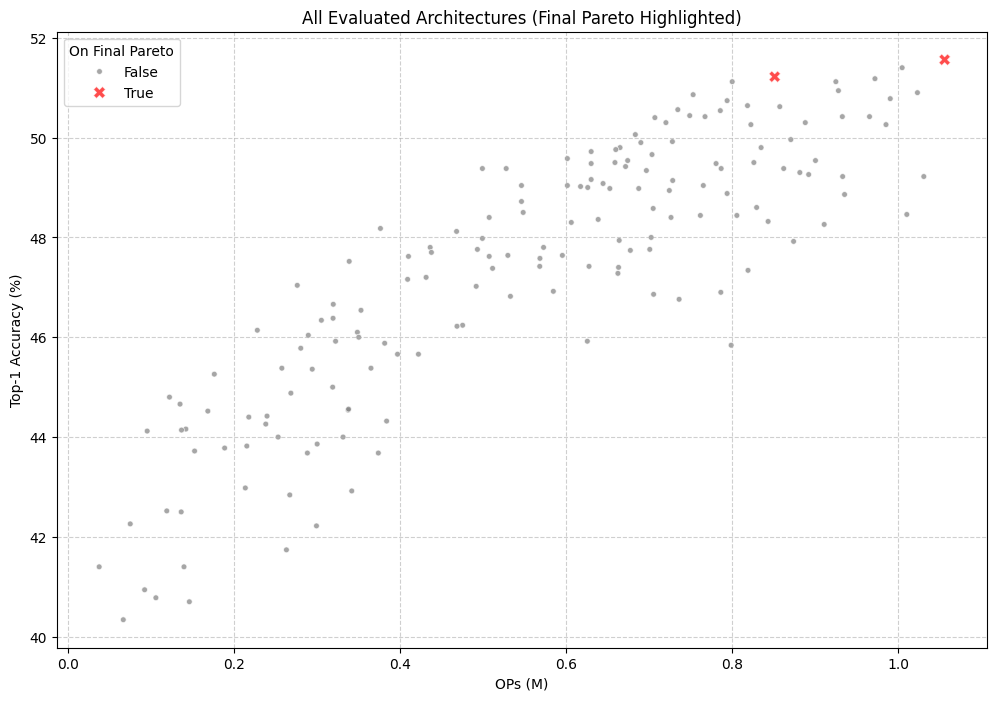


--- Analysis Complete ---


In [4]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast # For converting string tuples back to tuples if necessary
import os # Added for path check if needed, though not strictly used yet

# --- Configuration ---
search_info_file = "./work_dirs/cifar10_nasbnn_exp_notebook_run/search/info.pth.tar"
print(f"Attempting to load search results from: {search_info_file}")
if not os.path.exists(search_info_file):
    print(f"ERROR: The file {search_info_file} does not exist. Please check the path.")
    # Fallback to the other potential path if you ran the orchestrator script
    search_info_file_fallback = "./work_dirs/cifar10_nasbnn_exp_notebook_run/search/info.pth.tar"
    if os.path.exists(search_info_file_fallback):
        print(f"Attempting fallback path: {search_info_file_fallback}")
        search_info_file = search_info_file_fallback
    else:
        print("Fallback path also not found. Exiting analysis.")
        exit() # Or handle more gracefully in a notebook

# Initialize variables that will be populated from search_results
search_results = None
final_epoch_count = 0
vis_dict = {}
epoch_memories = [] # This will be search_results['memory']
final_pareto_global_dict = {} 
final_pareto_global_tuples = set()

try:
    search_results = torch.load(search_info_file, map_location='cpu')
    print("Search results loaded successfully.")
    
    final_epoch_count = search_results.get('epoch', 0) 
    vis_dict = search_results.get('vis_dict', {})
    epoch_memories = search_results.get('memory', []) 
    final_pareto_global_dict = search_results.get('pareto_global', {}) 
    if final_pareto_global_dict: # Ensure it's not None before calling .values()
        final_pareto_global_tuples = set(final_pareto_global_dict.values())

except FileNotFoundError:
    print(f"ERROR: Search info file not found at {search_info_file} even after fallback check.")
    search_results = None # Ensure it's None so subsequent blocks are skipped
except Exception as e:
    print(f"ERROR: Could not load search info file. Error: {e}")
    search_results = None # Ensure it's None

if not search_results:
    print("Cannot proceed with analysis as search results could not be loaded.")
    df_all_plot = pd.DataFrame() # Define as empty to prevent NameError later if plots are attempted
    df_final_pareto = pd.DataFrame()
else:
    print(f"\nTotal unique architectures evaluated (from vis_dict): {len(vis_dict)}")
    # 'epoch' in checkpoint is usually the *next* epoch to run, so completed is epoch-1
    completed_epochs = final_epoch_count 
    if final_epoch_count > 0 and len(epoch_memories) == final_epoch_count : # If epoch is 10, means epochs 0-9 ran
        print(f"Search completed {completed_epochs} evolutionary epochs (0 to {completed_epochs-1}).")
    else:
        print(f"Search 'epoch' field is {final_epoch_count}. Length of 'memory' field is {len(epoch_memories)}.")
        print("There might be a mismatch or the search didn't complete all evolutionary epochs as expected by 'memory' structure.")


    # --- Debug: Print content of 'memory' field ---
    if epoch_memories:
        print("\n--- Content of memory[0] (first 3 elements if available): ---")
        for i_mem, item_mem in enumerate(epoch_memories[0]):
            print(item_mem)
            if i_mem >= 2: break
        if len(epoch_memories) > 1:
            print("\n--- Content of memory[1] (first 3 elements if available): ---")
            for i_mem, item_mem in enumerate(epoch_memories[1]):
                print(item_mem)
                if i_mem >= 2: break
    else:
        print("\n'memory' field is empty or not found in search_results.")
    # --- End Debug Print ---


    # --- Analysis 1: New Candidates From 'memory' Field Per Epoch ---
    # This section's interpretation depends heavily on what 'memory' actually stores.
    # If memory[i] stores the successfully evaluated *new children* of epoch i:
    print("\n--- New Candidates from 'memory' Field Per Evolutionary Epoch ---")
    if not epoch_memories:
        print("No per-epoch 'memory' data found.")
    else:
        # Assuming memory has one entry per COMPLETED evolutionary epoch (0 to final_epoch_count-1)
        # The 'memory' field was populated in search.py as:
        #   if start_fresh: ... self.memory=[] ... (no append for initial random population)
        #   while self.epoch < self.max_epochs:
        #       self.memory.append([]) # For current_generation_parents
        #       for parent_tuple in current_generation_parents: self.memory[-1].append(parent_tuple)
        #       ...
        #       self.candidates = mutation + crossover
        #       # THE CRITICAL PART: what was appended to memory after this?
        #       # The original code was: self.memory[-1].append(cand_tuple) for each cand_tuple in self.candidates
        #       # My last version changed it to store parents.
        # Let's check the structure of your search.py that generated this info.pth.tar
        # If it was my last version, memory[i] are PARENTS for epoch i.
        # If it was an earlier version, memory[i] MIGHT be children from epoch i.
        
        # For now, let's assume memory[i] represents something generated/processed in epoch i.
        # The "2 new unique architectures" you saw was based on len(epoch_memories[i]).
        # This implies `epoch_memories[i]` itself was a list of these 2 candidates.

        for i, epoch_cands_list in enumerate(epoch_memories):
            num_listed_cands = 0
            if epoch_cands_list: # Check if the list for the epoch is not None or empty
                num_listed_cands = len(epoch_cands_list)
            
            print(f"Epoch {i}: 'memory' field lists {num_listed_cands} candidate tuples.")
            
            if num_listed_cands > 0:
                ops_this_epoch = []
                acc_this_epoch = []
                for cand_item in epoch_cands_list:
                    cand_tuple_key = None
                    if isinstance(cand_item, str):
                        try: cand_tuple_key = ast.literal_eval(cand_item)
                        except: pass
                    elif isinstance(cand_item, torch.Tensor): # Should not be tensor here
                        cand_tuple_key = tuple(cand_item.flatten().tolist())
                    else: # Assume tuple
                        cand_tuple_key = cand_item
                    
                    if cand_tuple_key and cand_tuple_key in vis_dict:
                        data_entry = vis_dict[cand_tuple_key]
                        ops_this_epoch.append(data_entry.get('ops', -1))
                        acc_this_epoch.append(data_entry.get('acc', -1))
                    else:
                        # This case means candidates listed in 'memory' are not in 'vis_dict'
                        # which would be very unusual if 'memory' lists evaluated children.
                        # More likely if 'memory' lists parents that might not themselves be re-evaluated.
                        ops_this_epoch.append(-2) # Mark differently
                        acc_this_epoch.append(-2)


                valid_ops = [op for op in ops_this_epoch if op >= 0] # Exclude -1 and -2
                valid_acc = [ac for ac in acc_this_epoch if ac >= 0]

                if valid_ops and valid_acc:
                    print(f"  Avg OPs (of those in vis_dict): {sum(valid_ops)/len(valid_ops):.4f}M, Avg Acc: {sum(valid_acc)/len(valid_acc):.2f}%")
                elif num_listed_cands > 0:
                    print(f"  (Could not retrieve valid OPs/Acc for some/all candidates listed in 'memory' for epoch {i} from vis_dict)")
            if num_listed_cands == 2 and i >= 2 and valid_ops and valid_acc: # Check if stats are identical
                 if abs(sum(valid_ops)/len(valid_ops) - 0.9539) < 1e-4 and abs(sum(valid_acc)/len(valid_acc) - 51.39) < 1e-2 :
                     print(f"  WARNING: Stats for epoch {i} match the repeating pattern (Avg OPs ~0.9539M, Avg Acc ~51.39%). Check 'memory' content.")


    # --- Analysis 2: Final Pareto Optimal Architectures ---
    print("\n--- Final Pareto Optimal Architectures (from loaded info.pth.tar's 'pareto_global') ---")
    if not final_pareto_global_dict: 
        print("Final Pareto front ('pareto_global') is empty or not found in info.pth.tar.")
        df_final_pareto = pd.DataFrame() # Ensure it's defined
    else:
        pareto_data = []
        for ops_bucket_key, cand_tuple_val in final_pareto_global_dict.items():
            cand_tuple_key_for_vis = None
            if isinstance(cand_tuple_val, str):
                try: cand_tuple_key_for_vis = ast.literal_eval(cand_tuple_val)
                except: cand_tuple_key_for_vis = cand_tuple_val 
            elif isinstance(cand_tuple_val, torch.Tensor):
                cand_tuple_key_for_vis = tuple(cand_tuple_val.flatten().tolist())
            else: 
                cand_tuple_key_for_vis = cand_tuple_val

            if cand_tuple_key_for_vis in vis_dict and 'acc' in vis_dict[cand_tuple_key_for_vis] and 'ops' in vis_dict[cand_tuple_key_for_vis]:
                pareto_data.append({
                    'OPs_Bucket_Key': ops_bucket_key,
                    'Accuracy (%)': vis_dict[cand_tuple_key_for_vis]['acc'],
                    'OPs (M)': vis_dict[cand_tuple_key_for_vis]['ops'],
                    'Architecture': str(cand_tuple_key_for_vis) 
                })
            else:
                print(f"Warning: Candidate {cand_tuple_key_for_vis} from pareto_global (key: {ops_bucket_key}) not found in vis_dict or lacks data.")

        if pareto_data:
            df_final_pareto = pd.DataFrame(pareto_data).sort_values(by='OPs (M)').reset_index(drop=True)
            with pd.option_context('display.max_colwidth', None, 'display.width', 1000):
                print(df_final_pareto)
        else:
            print("No data to display for the final Pareto front based on vis_dict.")
            df_final_pareto = pd.DataFrame() # Ensure it's defined

    # --- Analysis 3: Plot all evaluated candidates from vis_dict ---
    print("\n--- Plotting All Evaluated Architectures ---")
    all_evaluated_for_plot = []
    if vis_dict:
        for cand_tuple_key_plot, data_plot in vis_dict.items():
            current_cand_tuple_for_check_plot = None
            if isinstance(cand_tuple_key_plot, str):
                try: current_cand_tuple_for_check_plot = ast.literal_eval(cand_tuple_key_plot)
                except: pass
            elif isinstance(cand_tuple_key_plot, torch.Tensor): # Should not be tensor keys in vis_dict
                current_cand_tuple_for_check_plot = tuple(cand_tuple_key_plot.flatten().tolist())
            else: # Assume tuple
                current_cand_tuple_for_check_plot = cand_tuple_key_plot

            if 'acc' in data_plot and 'ops' in data_plot:
                all_evaluated_for_plot.append({
                    'ops': data_plot['ops'],
                    'accuracy': data_plot['acc'],
                    'on_final_pareto': current_cand_tuple_for_check_plot in final_pareto_global_tuples if current_cand_tuple_for_check_plot else False
                })
        df_all_plot = pd.DataFrame(all_evaluated_for_plot)

        if not df_all_plot.empty:
            plt.figure(figsize=(12, 8))
            # Ensure 'on_final_pareto' column exists and has boolean values for hue mapping
            if 'on_final_pareto' in df_all_plot.columns and df_all_plot['on_final_pareto'].isin([True, False]).all():
                sns.scatterplot(data=df_all_plot, x='ops', y='accuracy', hue='on_final_pareto',
                                palette={True: 'red', False: 'grey'}, style='on_final_pareto', 
                                markers={True: 'X', False: '.'}, s=70, alpha=0.7)
                plt.legend(title='On Final Pareto')
            else: # Fallback if 'on_final_pareto' is problematic
                print("Warning: 'on_final_pareto' column issue. Plotting all points uniformly.")
                sns.scatterplot(data=df_all_plot, x='ops', y='accuracy', color='grey', s=50, alpha=0.7)

            plt.title('All Evaluated Architectures (Final Pareto Highlighted)')
            plt.xlabel('OPs (M)')
            plt.ylabel('Top-1 Accuracy (%)')
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.show()
        else:
            print("No data in vis_dict to plot.")
            df_all_plot = pd.DataFrame() # Ensure it's defined
    else:
        print("vis_dict is empty. Cannot plot.")
        df_all_plot = pd.DataFrame() # Ensure it's defined

print("\n--- Analysis Complete ---")